In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-dataset-malignant-and-benign/35000 Dataset/Benign/ISIC_0065354.jpg
/kaggle/input/skin-cancer-dataset-malignant-and-benign/35000 Dataset/Benign/ISIC_0057312.jpg
/kaggle/input/skin-cancer-dataset-malignant-and-benign/35000 Dataset/Benign/ISIC_0059626.jpg
/kaggle/input/skin-cancer-dataset-malignant-and-benign/35000 Dataset/Benign/ISIC_0030912.jpg
/kaggle/input/skin-cancer-dataset-malignant-and-benign/35000 Dataset/Benign/ISIC_0035342.jpg
/kaggle/input/skin-cancer-dataset-malignant-and-benign/35000 Dataset/Benign/ISIC_0028933.jpg
/kaggle/input/skin-cancer-dataset-malignant-and-benign/35000 Dataset/Benign/ISIC_0030585.jpg
/kaggle/input/skin-cancer-dataset-malignant-and-benign/35000 Dataset/Benign/ISIC_0028394.jpg
/kaggle/input/skin-cancer-dataset-malignant-and-benign/35000 Dataset/Benign/ISIC_0066755.jpg
/kaggle/input/skin-cancer-dataset-malignant-and-benign/35000 Dataset/Benign/ISIC_0059705.jpg
/kaggle/input/skin-cancer-dataset-malignant-and-benign/35000 Dataset/B

In [2]:
# !pip install -q timm

import os
import time
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
# --- NEW LINES HERE ---
from PIL import Image, ImageFile
Image.MAX_IMAGE_PIXELS = None  
ImageFile.LOAD_TRUNCATED_IMAGES = True
# ----------------------
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets

import timm # PyTorch Image Models

# Set seeds for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Using device: cuda


In [3]:
CONFIG = {
    'data_dir': '/kaggle/input/skin-cancer-dataset-malignant-and-benign/35000 Dataset', # Adjust if your path is slightly different
    'img_size': 224,
    'batch_size': 16, # Lower to 16 if you run out of GPU memory
    'epochs': 20,     # Transformers need time to converge
    'learning_rate': 1e-4,
    'num_classes': 2,
    'num_workers': 4,
    'fold_split': 0.2 # 20% for validation/testing
}

In [4]:
# ImageNet statistics for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((CONFIG['img_size'], CONFIG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [5]:
# Load the full dataset
full_dataset = datasets.ImageFolder(root=CONFIG['data_dir'])

# Get dataset size and indices
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
split = int(np.floor(CONFIG['fold_split'] * dataset_size))

# Shuffle indices
np.random.shuffle(indices)
train_indices, val_test_indices = indices[split:], indices[:split]

# Split val_test into val and test (50/50 of the 20% split)
test_split = len(val_test_indices) // 2
val_indices = val_test_indices[test_split:]
test_indices = val_test_indices[:test_split]

# Create Subsets
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)

# Apply transforms manually to subsets (PyTorch Subset doesn't allow separate transforms easily)
# So we wrap them in a custom class
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

train_set = TransformedDataset(train_dataset, transform=data_transforms['train'])
val_set = TransformedDataset(val_dataset, transform=data_transforms['val'])
test_set = TransformedDataset(test_dataset, transform=data_transforms['test'])

# DataLoaders
dataloaders = {
    'train': DataLoader(train_set, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers']),
    'val': DataLoader(val_set, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers']),
    'test': DataLoader(test_set, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])
}

dataset_sizes = {'train': len(train_set), 'val': len(val_set), 'test': len(test_set)}
class_names = full_dataset.classes

print(f"Classes: {class_names}")
print(f"Train size: {dataset_sizes['train']}, Val size: {dataset_sizes['val']}, Test size: {dataset_sizes['test']}")

Classes: ['Benign', 'Malignant']
Train size: 28000, Val size: 3500, Test size: 3500


In [21]:
# --- UPDATE THE ENTIRE CONTENT OF CELL 5 WITH THIS CODE ---

def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, device, num_epochs=25, model_name="model"):
    """
    Trains and validates the PyTorch model, applying the learning rate scheduler.
    Saves the model weights that achieve the best validation accuracy.
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            # --- Key Scheduler Update ---
            if phase == 'train':
                scheduler.step()

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # --- History Tracking & Best Weights Check ---
            if phase == 'val':
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights and save
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), f'{model_name}_best.pth')
    
    return model, history

In [7]:
print("Initializing Model 1: EfficientNet B4...")

# Load Pretrained EfficientNet
model_cnn = timm.create_model('tf_efficientnet_b4_ns', pretrained=True)

# Modify the classifier for 2 classes
num_features = model_cnn.classifier.in_features
model_cnn.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, CONFIG['num_classes'])
)

model_cnn = model_cnn.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.AdamW(model_cnn.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
exp_lr_scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)

# Train CNN
model_cnn, history_cnn = train_model(
    model_cnn, criterion, optimizer_cnn, exp_lr_scheduler_cnn, 
    num_epochs=CONFIG['epochs'], model_name="EfficientNet"
)

Initializing Model 1: EfficientNet B4...


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b4_ns to current tf_efficientnet_b4.ns_jft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

Epoch 1/20
----------
train Loss: 0.4537 Acc: 0.7844
val Loss: 0.8059 Acc: 0.8300

Epoch 2/20
----------
train Loss: 0.3681 Acc: 0.8331
val Loss: 0.3548 Acc: 0.8437

Epoch 3/20
----------
train Loss: 0.3153 Acc: 0.8628
val Loss: 1.2977 Acc: 0.8669

Epoch 4/20
----------
train Loss: 0.2688 Acc: 0.8866
val Loss: 1.3589 Acc: 0.8671

Epoch 5/20
----------
train Loss: 0.2236 Acc: 0.9091
val Loss: 0.3076 Acc: 0.8757

Epoch 6/20
----------
train Loss: 0.1920 Acc: 0.9210
val Loss: 0.3097 Acc: 0.8820

Epoch 7/20
----------
train Loss: 0.1648 Acc: 0.9339
val Loss: 2.1616 Acc: 0.8874

Epoch 8/20
----------
train Loss: 0.1046 Acc: 0.9598
val Loss: 0.4458 Acc: 0.8929

Epoch 9/20
----------
train Loss: 0.0849 Acc: 0.9670
val Loss: 0.3219 Acc: 0.8954

Epoch 10/20
----------
train Loss: 0.0773 Acc: 0.9708
val Loss: 0.4193 Acc: 0.8983

Epoch 11/20
----------
train Loss: 0.0675 Acc: 0.9746
val Loss: 0.3309 Acc: 0.9037

Epoch 12/20
----------
train Loss: 0.0610 Acc: 0.9769
val Loss: 0.3544 Acc: 0.9026

E

In [13]:
print("Initializing Model 2: Vision Transformer (ViT)...")

# Load Pretrained ViT
model_vit = timm.create_model('vit_base_patch16_224', pretrained=True)

# Modify the head for 2 classes
num_features = model_vit.head.in_features
model_vit.head = nn.Sequential(
    nn.Linear(num_features, CONFIG['num_classes'])
)

model_vit = model_vit.to(device)

# Loss and Optimizer (ViT usually prefers slightly lower LR or different scheduling, but AdamW is good)
optimizer_vit = optim.AdamW(model_vit.parameters(), lr=5e-5, weight_decay=0.01) # Lower LR for ViT
exp_lr_scheduler_vit = lr_scheduler.StepLR(optimizer_vit, step_size=5, gamma=0.1)

# Train ViT
model_vit, history_vit = train_model(
    model_vit, criterion, optimizer_vit, exp_lr_scheduler_vit, 
    num_epochs=CONFIG['epochs'], model_name="ViT"
)

Initializing Model 2: Vision Transformer (ViT)...


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/20
----------
train Loss: 0.4670 Acc: 0.7692
val Loss: 0.4414 Acc: 0.7894

Epoch 2/20
----------
train Loss: 0.3982 Acc: 0.8139
val Loss: 0.3826 Acc: 0.8223

Epoch 3/20
----------
train Loss: 0.3657 Acc: 0.8320
val Loss: 0.4276 Acc: 0.8071

Epoch 4/20
----------
train Loss: 0.3356 Acc: 0.8479
val Loss: 0.3838 Acc: 0.8143

Epoch 5/20
----------
train Loss: 0.3115 Acc: 0.8625
val Loss: 0.3420 Acc: 0.8469

Epoch 6/20
----------
train Loss: 0.2060 Acc: 0.9125
val Loss: 0.2989 Acc: 0.8763

Epoch 7/20
----------
train Loss: 0.1662 Acc: 0.9318
val Loss: 0.3041 Acc: 0.8823

Epoch 8/20
----------
train Loss: 0.1432 Acc: 0.9418
val Loss: 0.3106 Acc: 0.8837

Epoch 9/20
----------
train Loss: 0.1193 Acc: 0.9512
val Loss: 0.3065 Acc: 0.8857

Epoch 10/20
----------
train Loss: 0.1040 Acc: 0.9586
val Loss: 0.3434 Acc: 0.8969

Epoch 11/20
----------
train Loss: 0.0792 Acc: 0.9695
val Loss: 0.3535 Acc: 0.8963

Epoch 12/20
----------
train Loss: 0.0737 Acc: 0.9710
val Loss: 0.3592 Acc: 0.8954

E

In [14]:
def evaluate_ensemble(modelA, modelB, dataloader):
    modelA.eval()
    modelB.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Model A Prediction
            outputsA = modelA(inputs)
            probsA = torch.softmax(outputsA, dim=1)
            
            # Model B Prediction
            outputsB = modelB(inputs)
            probsB = torch.softmax(outputsB, dim=1)
            
            # Ensemble (Soft Voting / Averaging)
            # You can adjust weights here, e.g., 0.6*probsA + 0.4*probsB
            avg_probs = (probsA + probsB) / 2.0 
            
            _, preds = torch.max(avg_probs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return np.array(all_preds), np.array(all_labels)

print("Evaluating Ensemble on Test Set...")
y_pred, y_true = evaluate_ensemble(model_cnn, model_vit, dataloaders['test'])

# Metrics
acc = accuracy_score(y_true, y_pred)
print(f"Ensemble Accuracy: {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Evaluating Ensemble on Test Set...
Ensemble Accuracy: 92.26%

Classification Report:
              precision    recall  f1-score   support

      Benign       0.92      0.93      0.92      1721
   Malignant       0.93      0.92      0.92      1779

    accuracy                           0.92      3500
   macro avg       0.92      0.92      0.92      3500
weighted avg       0.92      0.92      0.92      3500



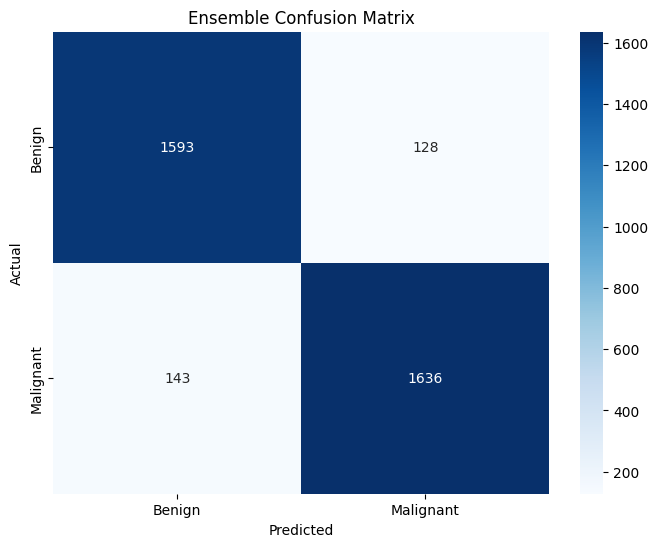

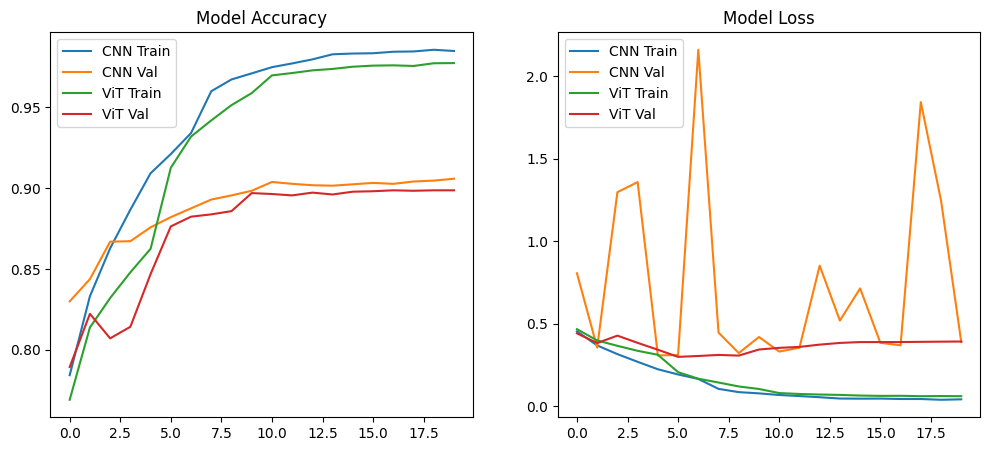

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Ensemble Confusion Matrix')
plt.show()

# Plot Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn['train_acc'], label='CNN Train')
plt.plot(history_cnn['val_acc'], label='CNN Val')
plt.plot(history_vit['train_acc'], label='ViT Train')
plt.plot(history_vit['val_acc'], label='ViT Val')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn['train_loss'], label='CNN Train')
plt.plot(history_cnn['val_loss'], label='CNN Val')
plt.plot(history_vit['train_loss'], label='ViT Train')
plt.plot(history_vit['val_loss'], label='ViT Val')
plt.title('Model Loss')
plt.legend()
plt.show()

In [16]:
def predict_image(image_path, modelA, modelB):
    modelA.eval()
    modelB.eval()
    
    # Preprocess
    img = Image.open(image_path).convert('RGB')
    transform = data_transforms['test']
    img_t = transform(img).unsqueeze(0).to(device) # Add batch dimension
    
    with torch.no_grad():
        outA = torch.softmax(modelA(img_t), dim=1)
        outB = torch.softmax(modelB(img_t), dim=1)
        
        # Ensemble
        combined_prob = (outA + outB) / 2.0
        conf, pred_class = torch.max(combined_prob, 1)
        
    return class_names[pred_class.item()], conf.item()

# Example usage (replace with a real path from your dataset to test)
img_path = '/kaggle/input/test-data/ISIC_0053466.jpg'
label, confidence = predict_image(img_path, model_cnn, model_vit)
print(f"Prediction: {label} with confidence {confidence:.2f}")

Prediction: Benign with confidence 1.00


In [18]:
import torch
import os

# Define the directory where you want to save the output files (Kaggle default)
SAVE_DIR = '/kaggle/working/' 

# 1. Save the final best weights for the CNN model
cnn_save_path = os.path.join(SAVE_DIR, 'final_cnn_weights.pth')
torch.save(model_cnn.state_dict(), cnn_save_path)
print(f"✅ EfficientNet weights saved to: {cnn_save_path}")

# 2. Save the final best weights for the ViT model
vit_save_path = os.path.join(SAVE_DIR, 'final_vit_weights.pth')
torch.save(model_vit.state_dict(), vit_save_path)
print(f"✅ Vision Transformer weights saved to: {vit_save_path}")

# 3. Note on the Ensemble:
print("\n📝 The ensemble is a function that combines these two models; you only need to save the individual model weights.")

✅ EfficientNet weights saved to: /kaggle/working/final_cnn_weights.pth
✅ Vision Transformer weights saved to: /kaggle/working/final_vit_weights.pth

📝 The ensemble is a function that combines these two models; you only need to save the individual model weights.


In [22]:
# --- RUN THIS CODE BLOCK AS A NEW CELL ---

import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F # Needed for the ensemble logic

# --- Configuration for Final Push ---
FINETUNE_EPOCHS = 5  # Run for a few more epochs
CRITERION = nn.CrossEntropyLoss()

print("==================================================")
print("  STARTING FINAL AGGRESSIVE FINE-TUNING PUSH  ")
print("==================================================")

# ----------------------------------------------------
# A. Fine-Tune EfficientNet (CNN)
# ----------------------------------------------------
print("\n--- 1. Fine-Tuning EfficientNet (CNN) ---")

FINAL_LR_CNN = 5e-6 

# Re-initialize Optimizer
optimizer_cnn_final = optim.AdamW(
    model_cnn.parameters(), 
    lr=FINAL_LR_CNN, 
    weight_decay=1e-4
)

# Use CosineAnnealing Scheduler
scheduler_cnn_final = lr_scheduler.CosineAnnealingLR(
    optimizer_cnn_final, 
    T_max=FINETUNE_EPOCHS 
)

# Train CNN
model_cnn, history_cnn_final = train_model(
    model_cnn, CRITERION, optimizer_cnn_final, scheduler_cnn_final, 
    dataloaders, dataset_sizes, device,
    num_epochs=FINETUNE_EPOCHS, 
    model_name="EfficientNet_Final"
)
print("------------------------------------------")


# ----------------------------------------------------
# B. Fine-Tune Vision Transformer (ViT)
# ----------------------------------------------------
print("\n--- 2. Fine-Tuning Vision Transformer (ViT) ---")

FINAL_LR_VIT_BACKBONE = 1e-6 
FINAL_LR_VIT_HEAD = 1e-4      

# Re-initialize Optimizer with specialized parameter groups
optimizer_vit_final = optim.AdamW(
    [
        # Backbone (Most layers) get a very small LR
        {'params': [p for name, p in model_vit.named_parameters() if 'head' not in name], 
         'lr': FINAL_LR_VIT_BACKBONE, 'weight_decay': 1e-4},
        
        # Head (New classification layer) gets a slightly higher LR
        {'params': model_vit.head.parameters(), 
         'lr': FINAL_LR_VIT_HEAD, 'weight_decay': 0.0}
    ],
    lr=FINAL_LR_VIT_BACKBONE # Base LR
)

# Use CosineAnnealing Scheduler
scheduler_vit_final = lr_scheduler.CosineAnnealingLR(
    optimizer_vit_final, 
    T_max=FINETUNE_EPOCHS
)

# Train ViT
model_vit, history_vit_final = train_model(
    model_vit, CRITERION, optimizer_vit_final, scheduler_vit_final, 
    dataloaders, dataset_sizes, device,
    num_epochs=FINETUNE_EPOCHS, 
    model_name="ViT_Final"
)
print("------------------------------------------")


# ----------------------------------------------------
# C. Weighted Ensemble Evaluation
# ----------------------------------------------------
print("\n--- 3. Final Weighted Ensemble Evaluation ---")

# Retrieve the best accuracy achieved during the final fine-tuning round
# We use the final history object from the last training run to calculate weights
try:
    best_acc_cnn = max(history_cnn_final['val_acc'])
    best_acc_vit = max(history_vit_final['val_acc'])
except:
    # Fallback to general history if final history doesn't exist
    best_acc_cnn = max(history_cnn['val_acc'])
    best_acc_vit = max(history_vit['val_acc'])


total_acc = best_acc_cnn + best_acc_vit
weight_cnn = best_acc_cnn / total_acc
weight_vit = best_acc_vit / total_acc

print(f"Calculated Weights: CNN={weight_cnn:.4f}, ViT={weight_vit:.4f}")


def evaluate_weighted_ensemble(model_cnn, model_vit, dataloader, weight_cnn, weight_vit):
    model_cnn.eval()
    model_vit.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs_cnn = model_cnn(inputs)
            outputs_vit = model_vit(inputs)
            
            probs_cnn = F.softmax(outputs_cnn, dim=1)
            probs_vit = F.softmax(outputs_vit, dim=1)

            # Weighted Averaging: Final_Prob = (Prob_CNN * Weight_CNN) + (Prob_ViT * Weight_ViT)
            ensemble_probs = (probs_cnn * weight_cnn) + (probs_vit * weight_vit)

            _, ensemble_preds = torch.max(ensemble_probs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(ensemble_preds.cpu().numpy())
            
    acc = accuracy_score(y_true, y_pred)
    print(f'\nWeighted Ensemble FINAL TEST ACCURACY: {acc*100:.4f}%')
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    return acc

final_accuracy = evaluate_weighted_ensemble(
    model_cnn, model_vit, dataloaders['test'], weight_cnn, weight_vit
)

  STARTING FINAL AGGRESSIVE FINE-TUNING PUSH  

--- 1. Fine-Tuning EfficientNet (CNN) ---
Epoch 0/4
----------
train Loss: 0.0387 Acc: 0.9855
val Loss: 0.3972 Acc: 0.9031
Epoch 1/4
----------
train Loss: 0.0363 Acc: 0.9866
val Loss: 0.3773 Acc: 0.9020
Epoch 2/4
----------
train Loss: 0.0370 Acc: 0.9860
val Loss: 2.6429 Acc: 0.9009
Epoch 3/4
----------
train Loss: 0.0355 Acc: 0.9873
val Loss: 6.6038 Acc: 0.8983
Epoch 4/4
----------
train Loss: 0.0351 Acc: 0.9874
val Loss: 1.5140 Acc: 0.9011
Training complete in 30m 39s
Best val Acc: 0.903143
------------------------------------------

--- 2. Fine-Tuning Vision Transformer (ViT) ---
Epoch 0/4
----------
train Loss: 0.0653 Acc: 0.9753
val Loss: 0.4020 Acc: 0.8966
Epoch 1/4
----------
train Loss: 0.0593 Acc: 0.9767
val Loss: 0.4106 Acc: 0.9000
Epoch 2/4
----------
train Loss: 0.0541 Acc: 0.9787
val Loss: 0.4277 Acc: 0.8971
Epoch 3/4
----------
train Loss: 0.0520 Acc: 0.9804
val Loss: 0.4259 Acc: 0.8971
Epoch 4/4
----------
train Loss: 0.04